In [66]:
import json
import multiprocessing
from pathlib import Path
import threading

# from absl.flags import FLAGS
import cv2
import numpy as np
from pycocotools.coco import COCO
import tensorflow as tf
from tqdm import tqdm

In [67]:
from matplotlib import pyplot as plt

In [68]:
class TFRecordsGenerator(object):
    def __init__(self, data_dir, input_size):
        self.data_dir = Path(data_dir)
        self.input_size = input_size
        self._db = []
        self._nproc = multiprocessing.cpu_count()
        self._num_bbox = 0
        self._writers = []
        self._write_locks = [threading.RLock() for _ in range(self._nproc)]

    def run(self):
        for train in [False]:
            # self._db = self._get_coco(train) + self._get_posetrack(train) + self._get_widerperson(train)
            self._db = self._get_widerperson(train)
            self._num_bbox = self._max_num_bbox()
            tfrecords_dir = self.data_dir / 'tfrecords' / f'{"train" if train else "val"}_{self.input_size}'
            if not tfrecords_dir.exists():
                tfrecords_dir.mkdir(parents=True)
            self._writers = [
                tf.io.TFRecordWriter(
                    str(tfrecords_dir /
                        f'{i:02d}-of-{self._nproc - 1:02d}.tfrecords'))
                for i in range(self._nproc)
            ]

            total = len(self._db)
            with multiprocessing.pool.ThreadPool(self._nproc) as pool:
                for _ in tqdm(pool.imap(self._write, range(total)),
                              total=total,
                              unit=' records'):
                    pass
            plt.show()
            
            for lock, writer in zip(self._write_locks, self._writers):
                with lock:
                    writer.close()
            self._writers = []
            self._db = []
            self._num_bbox = 0

    def _max_num_bbox(self):
        num_bbox = 0
        for data in self._db:
            num_bbox = max(num_bbox, len(data['bboxes']))
        return num_bbox

    def _write(self, i):
        idx = i % self._nproc
        with self._write_locks[idx]:
            self._writers[idx].write(
                self._single_data_to_example(self._db[i]).SerializeToString())

    def _single_data_to_example(self, single_data):
        resized = self._resize_and_pad(single_data)
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image_raw': self._bytes_feature(resized['image_raw']),
                'bboxes': self._float_list_feature(resized['bboxes'])
            }))

        return example

    def _resize_and_pad(self, single_data):
        image = cv2.imread(single_data['image'],
                           cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

        w = single_data['width']
        h = single_data['height']
        

        image_long_side = max(w, h)
        border_x = (image_long_side - w) / 2
        border_y = (image_long_side - h) / 2
        border_top = np.int(np.floor(border_y))
        border_bottom = np.int(np.ceil(border_y))
        border_left = np.int(np.floor(border_x))
        border_right = np.int(np.ceil(border_x))

        padded_image = cv2.copyMakeBorder(image, border_top, border_bottom,
                                          border_left, border_right,
                                          cv2.BORDER_CONSTANT)
        resized_image = cv2.resize(padded_image,
                                   dsize=(self.input_size, self.input_size),
                                   interpolation=cv2.INTER_AREA)

        bboxes = np.array(single_data['bboxes'])
        ratio = (self.input_size - 1) / (image_long_side - 1)
        resized_bboxes = (bboxes + [border_left, border_top] * 2) * ratio
        padded_bboxes = np.pad(resized_bboxes,
                               ((0, self._num_bbox - len(resized_bboxes)),
                                (0, 0)))
            
    #-------------------------------------------------------------------------------
        check_list = [10493, 5045, 7128, 8876, 13317, 12348]
            
        if single_data['image_id'] in check_list:            
            
            img = image
            re_img = resized_image
            bboxes = np.array(single_data['bboxes'])
            
            for (bbox_item, re_bbox_item) in zip(bboxes,padded_bboxes):    

                cv2.rectangle(img, (int(bbox_item[0]),int(bbox_item[1])), 
                            (int(bbox_item[2]),int(bbox_item[3])), (0,255,0),1)
                
                cv2.rectangle(re_img, (int(re_bbox_item[0]),int(re_bbox_item[1])), 
                            (int(re_bbox_item[2]),int(re_bbox_item[3])), (0,255,0),1)
            

            fig = plt.figure(figsize=(15,15))
            rows = 1
            cols = 2

            ax1 = fig.add_subplot(rows, cols, 1)
            ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax1.set_title('raw image')
            ax1.axis("off")
            
            ax2 = fig.add_subplot(rows, cols, 2)
            ax2.imshow(cv2.cvtColor(re_img, cv2.COLOR_BGR2RGB))
            ax2.set_title('resized image')
            ax2.axis("off")
            
            print("image_id:",single_data['image_id'],", image.shape: {0}".format(img.shape)
                  ,", resized_image.shape: {0}".format(resized_image.shape))
            
            
    #-------------------------------------------------------------------------------       
                
                
        return {
            'image_raw':
            cv2.imencode('.jpg', resized_image,
                         [cv2.IMWRITE_JPEG_QUALITY, 100])[1].tostring(),
            'bboxes':
            padded_bboxes.reshape(-1)
        }

    def _bytes_feature(self, value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _float_list_feature(self, value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))

    def _int64_feature(self, value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def _get_widerperson(self, train):
        db = []
        annot_file = self.data_dir / f'WiderPerson_{"train" if train else "val"}2019.json'
        if not annot_file.exists():
            self._widerperson2coco(train)

        coco = COCO(annot_file)
        person_cat_id = coco.getCatIds(catNms='person')
        person_img_ids = coco.getImgIds(catIds=person_cat_id)

        for person_img_id in person_img_ids:
            person_ann_ids = coco.getAnnIds(imgIds=person_img_id,
                                            areaRng=(0, np.inf),
                                            iscrowd=False)
            person_objs = coco.loadAnns(person_ann_ids)

            bboxes = []
            width = coco.imgs[person_img_id]['width']
            height = coco.imgs[person_img_id]['height']
            for person in person_objs:
                x1, y1, x2, y2 = person['bbox']
                if x1 >= x2 or y1 >= y2:
                    continue
                    
                bboxes.append([x1, y1, x2, y2])
                
            if not bboxes:
                continue
            file_name = coco.imgs[person_img_id]['file_name']
            image_path = str(self.data_dir / 'WiderPerson' / 'Images' /
                             file_name)

            db.append({
                'image': image_path,
                'bboxes': bboxes,
                'width': width,
                'height': height,
                'image_id': person_img_id
            })

        return db

    def _widerperson2coco(self, train):

        annot_path = self.data_dir / 'WiderPerson' / 'Annotations'
        img_path = self.data_dir / 'WiderPerson' / 'Images'

        coco = {'images': [], 'categories': [], 'annotations': []}

        img_v = []
        anno_v = []
        categ_v = []

        with open(self.data_dir / 'WiderPerson' /
                  f'{"train" if train else "val"}.txt') as f:
            for item in tqdm(f.readlines(), unit=' files'):
                file_name = item.rstrip('\n') + '.jpg'
                with (open(annot_path / f'{file_name}.txt')) as anno_f:
                    img = cv2.imread(str(img_path / f'{file_name}'))
                    h, w, c = img.shape
                    annot = anno_f.readlines()
                    img_info = {
                        'file_name': file_name,
                        'coco_url': 'invalid',
                        'height': h,
                        'width': w,
                        'id': np.int(file_name.split('.')[0])
                    }

                    exist = False
                    for (i, line) in zip(range(-1, len(annot)), annot):
                        bbox_split = line.strip().split(' ')
                        if i != -1 and bbox_split[0] < '4':
                            exist = True
                            bbox_info = {
                                'bbox': [
                                    np.float64(bbox_split[1]),
                                    np.float64(bbox_split[2]),
                                    np.float64(bbox_split[3]),
                                    np.float64(bbox_split[4])
                                ],
                                'area':
                                np.float64(bbox_split[3]) *
                                np.float64(bbox_split[4]),
                                'image_id':
                                np.int(file_name.split('.')[0]),
                                'category_id':
                                1,
                                'id':
                                (np.int(file_name.split('.')[0]) + 10**7) *
                                10**4 + i,
                                'iscrowd':
                                0
                            }
                            anno_v.append(bbox_info)

                    if exist: img_v.append(img_info)

            categ_info = {'supercategory': "person", 'id': 1, 'name': "person"}
            categ_v.append(categ_info)

            coco['images'].extend(img_v)
            coco['annotations'].extend(anno_v)
            coco['categories'].extend(categ_v)

        with open(
                self.data_dir /
                f'WiderPerson_{"train" if train else "val"}2019.json',
                'w') as f:
            json.dump(coco, f)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


 14%|█▍        | 144/1000 [00:00<00:02, 333.52 records/s]

image_id: 12348 , image.shape: (400, 600, 3) , resized_image.shape: (512, 512, 3)
image_id: 10493 , image.shape: (450, 600, 3) , resized_image.shape: (512, 512, 3)


 42%|████▏     | 416/1000 [00:00<00:01, 420.22 records/s]

image_id: 8876 , image.shape: (511, 400, 3) , resized_image.shape: (512, 512, 3)
image_id: 5045 , image.shape: (358, 516, 3) , resized_image.shape: (512, 512, 3)
image_id: 7128 , image.shape: (386, 610, 3) , resized_image.shape: (512, 512, 3)
image_id: 13317 , image.shape: (597, 899, 3) , resized_image.shape: (512, 512, 3)


100%|██████████| 1000/1000 [00:01<00:00, 830.34 records/s]


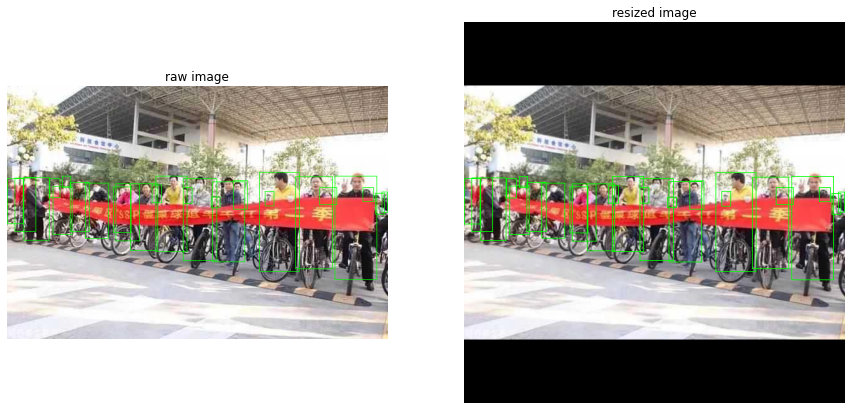

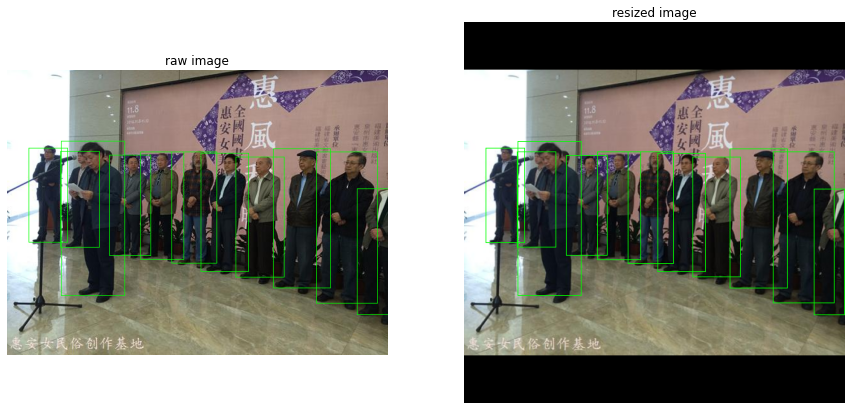

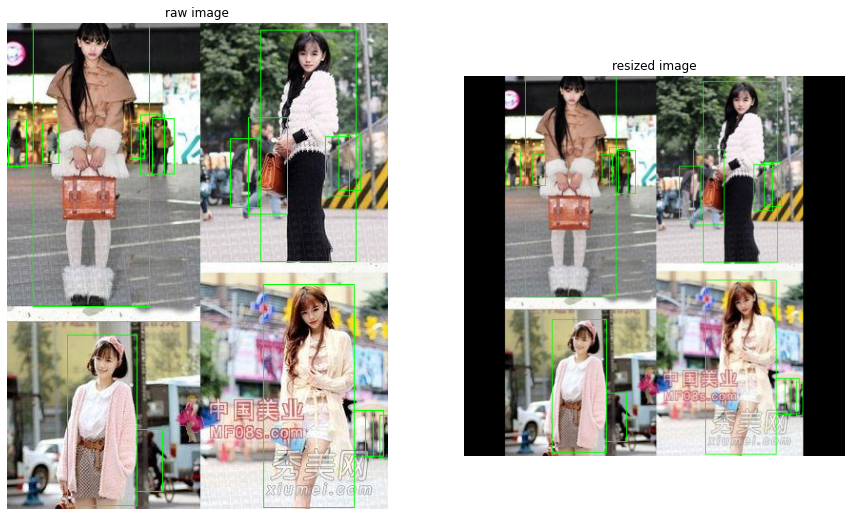

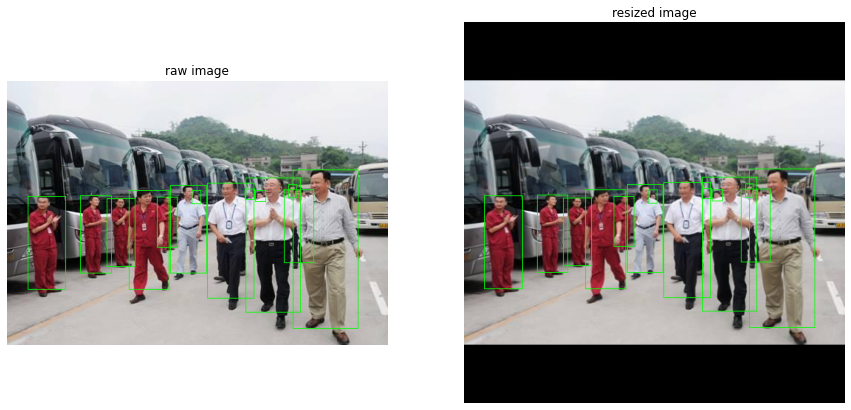

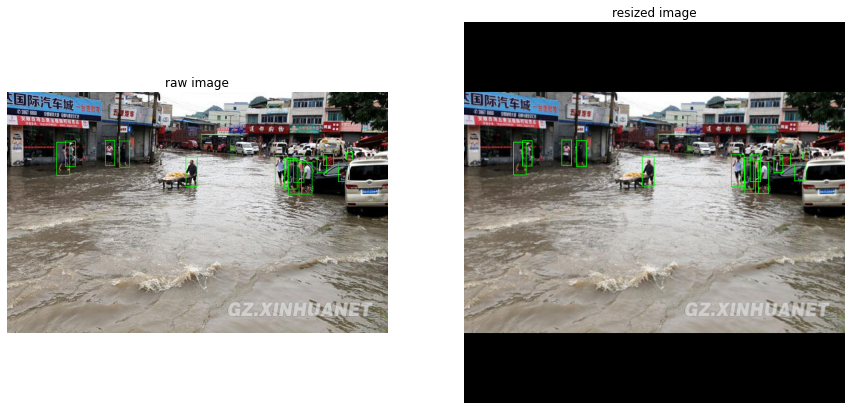

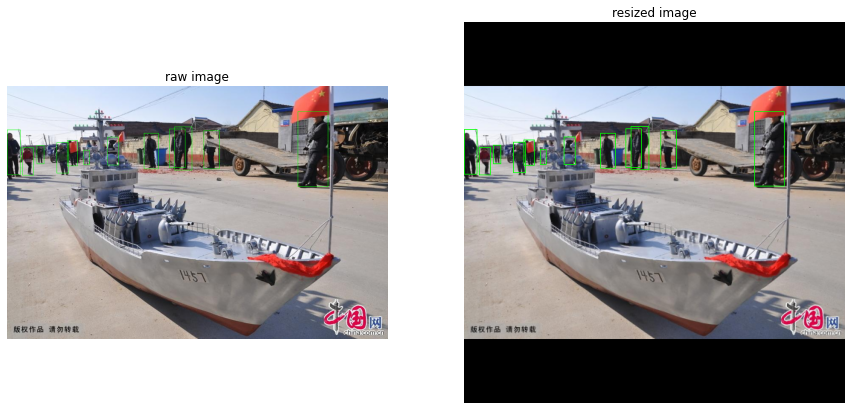

In [69]:
TFRecordsGenerator('data', 512).run()

In [70]:
def widerperson_test(data_dir, train):
    data_dir = Path(data_dir)
    annot_file = data_dir / f'WiderPerson_{"train" if train else "val"}2019.json'
    annot_path = data_dir / 'WiderPerson' / 'Annotations'

    coco = COCO(annot_file)
    person_cat_id = coco.getCatIds(catNms='person')
    person_img_ids = coco.getImgIds(catIds=person_cat_id)
    person_anno_ids = coco.getAnnIds(areaRng=(0, np.inf), iscrowd=False)

    n_bbox = 0
    with open(data_dir / 'WiderPerson' /
                  f'{"train" if train else "val"}.txt') as f:
        items = f.readlines()
        for item in items:
            file_name = item.rstrip('\n') + '.jpg'
            with (open(annot_path / f'{file_name}.txt')) as anno_f:
                annot = anno_f.readlines()
                for (i, line) in zip(range(-1, len(annot)), annot):
                    bbox_split = line.strip().split(' ')
                    if i != -1 and bbox_split[0] < '4':
                        n_bbox = n_bbox + 1

    print('\n----test----------------------------------------------------------------------')
    print("\nimg 개수 확인:", len(person_img_ids) == len(items))
    print("COCO json - img 개수:", len(person_img_ids))
    print("txt file - img 개수:", len(items))

    print("\nbbox 개수 확인:", len(person_anno_ids) == n_bbox)
    print("COCO json - bbox 개수:", len(person_anno_ids))
    print("txt file - classlabel 1,2,3인 bbox 개수:", n_bbox)
    print(
            '------------------------------------------------------------------------------'
        )

In [71]:
widerperson_test('data', False)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!

----test----------------------------------------------------------------------

img 개수 확인: True
COCO json - img 개수: 1000
txt file - img 개수: 1000

bbox 개수 확인: True
COCO json - bbox 개수: 27353
txt file - classlabel 1,2,3인 bbox 개수: 27353
------------------------------------------------------------------------------
